### Initiating Google Colab

In [ ]:
from google.colab import drive, auth

drive.mount('/content/drive', force_remount=True)
auth.authenticate_user()

BUCKET_NAME = 'cancer_detection_colab'
! gsutil ls gs://{BUCKET_NAME}

### Importing Libraries

In [1]:
import sys
LIBRARY_DIR = '/home/sven/Python/TensorFlow-Training/Text'
# LIBRARY_DIR = '/content/drive/My Drive'
sys.path.append(LIBRARY_DIR)

import numpy as np
import pandas as pd
import tensorflow as tf
import os
import time
from math import ceil as ceil
import datetime
import logging
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from utils.models.skin_cancer_detector import create_labels_with_counts, sort_samples, create_dataset, load_dataset, print_scores



# disable warnings and infos
logging.disable(logging.ERROR)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

tf.__version__

'2.3.1'

In [2]:
tf.test.is_gpu_available()

True

### Initiating a GPU strategy

In [3]:
for gpu in tf.config.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, enable=True)
    
#tf.config.set_visible_devices([], device_type='GPU')
#print(tf.config.get_visible_devices())
strategy = tf.distribute.MirroredStrategy(['/gpu:0'])

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


### Initiating a TPU strategy

In [ ]:
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    print('Running on TPU: ', resolver.cluster_spec().as_dict())
except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime')
    
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

strategy = tf.distribute.TPUStrategy()

### Setting up some parameters

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE


BASE_DIR = ''
# BASE_DIR = f'gs://{BUCKET_NAME}'   # for Colab
VERSION = 3
MODEL_DIR = os.path.join(BASE_DIR, 'model', f'{VERSION:04d}')
LOGS_DIR = os.path.join(BASE_DIR, 'logs')
CHECKPOINT_DIR = os.path.join(BASE_DIR, 'checkpoints')
DATASET_DIR = '/home/sven/tensorflow_datasets/ISIC_2019'
# DATASET_DIR = BASE_DIR   # for Colab


BATCH_SIZE = 64 * strategy.num_replicas_in_sync    # divide by 2 for TPU usage
BUFFER_SIZE = 10000
IMAGE_SIZE = [150, 150]
VALIDATION_SPLIT = 0.2 

In [31]:
dataset = pd.read_csv(os.path.join(DATASET_DIR, 'ISIC_2019_Training_GroundTruth.csv'))
dataset

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As the labels are one-hot encoded, we create another column 'LABEL' containing the correct label as a string. The resulting file is written to disk.

In [34]:
LABELS = dataset.columns[1:]
for idx in dataset.index:
    dataset.loc[idx, 'LABEL'] = LABELS[np.argmax(dataset.iloc[idx, 1:])]

dataset.to_csv(os.path.join(DATASET_DIR, 'ISIC_2019_Training.csv'))
dataset

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,LABEL
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
...,...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,BCC
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BKL
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV


In [5]:
LABELS, COUNTS = create_labels_with_counts(directory=DATASET_DIR, metadata_file='ISIC_2019_Training.csv', target_key='LABEL')
for label in LABELS:
    print(f"{COUNTS[label]} samples for label '{label}'")
    
    
    
# Here is an alternative dataset
#gcs_pattern = 'gs://flowers-public/tfrecords-jpeg-331x331/*.tfrec'
#LABELS = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] 

12875 samples for label 'NV'
4522 samples for label 'MEL'
3323 samples for label 'BCC'
2624 samples for label 'BKL'
867 samples for label 'AK'
628 samples for label 'SCC'
253 samples for label 'VASC'
239 samples for label 'DF'


# Loading the dataset

### Creating a preprocessed dataset

In [36]:
IMAGE_DIR = os.path.join(DATASET_DIR, 'images')
#sort_samples(source_dir = DATASET_DIR, target_dir = IMAGE_DIR, metadata_file='ISIC_2019_Training.csv', target_key='LABEL', image_key='image', subfolders=['ISIC_2019_Training_Input'])

# create_dataset(source_dir = IMAGE_DIR,
#               target_dir = DATASET_DIR,   
#               image_size = IMAGE_SIZE,   
#               validation_split = VALIDATION_SPLIT,   
#               mode = 'tfrecord',   
#               shard_size = 500)

### Using Kera's ImageDataGenerator

In [104]:
image_gen = ImageDataGenerator(rescale = 1./255,
                              # height_shift_range = 0.2,
                              # width_shift_range = 0.2,
                              # rotation_range = 90,
                              # zoom_range = 0.2,
                              # shear_range = 45,
                              # horizontal_flip = True,
                              # vertical_flip = True,
                               validation_split = VALIDATION_SPLIT)

directory = os.path.join(DATASET_DIR, f'{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}')

train_data = image_gen.flow_from_directory(directory = directory, 
                                           target_size = IMAGE_SIZE, 
                                           batch_size = BATCH_SIZE,
                                           class_mode = 'sparse',
                                           subset = 'training',
                                           classes = LABELS)

valid_data = image_gen.flow_from_directory(directory = directory, 
                                           target_size = IMAGE_SIZE, 
                                           batch_size = BATCH_SIZE,
                                           class_mode = 'sparse',
                                           subset = 'validation', 
                                           classes = LABELS)

Found 8015 images belonging to 7 classes.
Found 2000 images belonging to 7 classes.


### Using Kera's image_dataset_from_directory (requires TF version 2.3)

In [8]:
directory = os.path.join(DATASET_DIR, f'{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}')

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=IMAGE_DIR,
    class_names=LABELS,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    validation_split=VALIDATION_SPLIT,
    subset='training',
    seed=1)

train_data = train_data.map(lambda x,y: (x/255., y), num_parallel_calls=AUTOTUNE)
train_data = train_data.cache().repeat().prefetch(AUTOTUNE)

valid_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=IMAGE_DIR,
    class_names=LABELS,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    validation_split=VALIDATION_SPLIT,
    subset='validation',
    seed=1)

valid_data = valid_data.map(lambda x,y: (x/255., y), num_parallel_calls=AUTOTUNE)
valid_data = valid_data.cache().repeat().prefetch(AUTOTUNE)
n_train = 8012
n_valid = 2003

Found 10015 files belonging to 7 classes.
Using 8012 files for training.
Found 10015 files belonging to 7 classes.
Using 2003 files for validation.


### Creating a (balanced) dataset by hand

In [6]:
mode = 'tfrecord'
train_dir = os.path.join(DATASET_DIR, f'{mode}_{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}', 'training')
valid_dir = os.path.join(DATASET_DIR, f'{mode}_{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}', 'validation')

train_data, n_train = load_dataset(directory=train_dir, 
                          mode=mode, 
                          batch_size=BATCH_SIZE, 
                          balanced=True, 
                          augmented=True,
                          image_size=IMAGE_SIZE)

valid_data, n_valid = load_dataset(directory=valid_dir, 
                          mode=mode, 
                          batch_size=BATCH_SIZE, 
                          balanced=True, 
                          augmented=False,
                          image_size=IMAGE_SIZE)


train_steps = ceil(n_train/BATCH_SIZE)
valid_steps = ceil(n_valid/BATCH_SIZE)
print(f'{n_train} training samples in {train_steps} batches')
print(f'{n_valid} validation samples in {valid_steps} batches')

20269 training samples in 317 batches
5062 validation samples in 80 batches


### Inspecting batch number 10001

loaded the data in 1.217 seconds

image batch has shape (64, 150, 150, 3) and dtype float32
label batch has shape (64,) and dtype int64
number of images per label: [10, 13, 9, 5, 7, 1, 8, 11]

class of first image:  DF
a part of the first image:
 [[0.36862746 0.3372549  0.32156864 0.34901962]
 [0.32941177 0.3137255  0.31764707 0.3137255 ]
 [0.3372549  0.3647059  0.33333334 0.33333334]
 [0.34901962 0.35686275 0.3254902  0.27450982]]


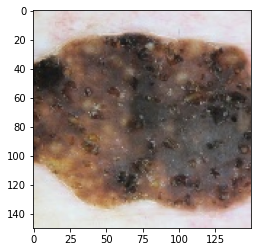

In [7]:
start = time.perf_counter()
x, y = next(iter(valid_data.skip(10000)))
print(f'loaded the data in {time.perf_counter()-start:.3f} seconds\n', )
print(f'image batch has shape {x.shape} and dtype {x.dtype.name}')
print(f'label batch has shape {y.shape} and dtype {y.dtype.name}')

l = len(LABELS)*[0]
for e in y:
    l[e.numpy()] += 1
print('number of images per label:', l)

print('\nclass of first image: ', LABELS[y[0].numpy()])
print('a part of the first image:\n', x[0,50:54,50:54,0].numpy())
res = plt.imshow(x[0])

# Buidling and training a model

## 1st Model

In [14]:
with strategy.scope():
    model1 = Sequential([
             Conv2D(16, [3,3], activation='relu', input_shape=[*IMAGE_SIZE,3]),
             Conv2D(16, [3,3], activation='relu'),
             MaxPooling2D([3,3]),
             Dropout(0.2),
             Conv2D(32, [3,3], activation='relu'),
             Conv2D(32, [3,3], activation='relu'),
             MaxPooling2D([3,3]),
             Dropout(0.2),
             Flatten(),
             Dense(512, activation='relu'),
             Dense(len(LABELS), activation='softmax')
             ])
    
    model1.compile(loss='sparse_categorical_crossentropy',
                   optimizer=tf.keras.optimizers.Adam(lr=0.001),
                   metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
                  )
    
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 146, 146, 16)      2320      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 46, 46, 32)        4640      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 44, 44, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)       

In [15]:
ES = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', min_delta=0.001, patience=50, mode='max', restore_best_weights=True)
TB = tf.keras.callbacks.TensorBoard(log_dir=os.path.join(LOGS_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10)
model1.fit(train_data, 
          validation_data=valid_data, 
          steps_per_epoch=train_steps, 
          epochs=500, 
          validation_steps=valid_steps, 
          verbose=0, 
          callbacks=[ES, TB, LR]
         )

### Inspecting the accuracy of the model

Accuracy: 43.16%
AUC: 80.92%
Jaccard: 28.35%
F1: 42.72%
Confusion Matrix


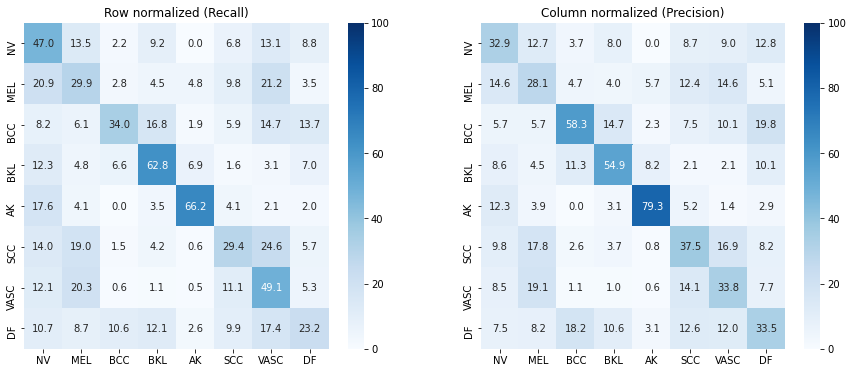

In [13]:
print_scores(model=model1, test_data=valid_data.take(valid_steps), labels=LABELS)

In [53]:
model.save(MODEL_DIR)

## 2nd Model

In [8]:
with strategy.scope():
    model2 = Sequential([
            Conv2D(16, 3, padding = 'same', activation = 'relu', input_shape = [*IMAGE_SIZE, 3]),
            MaxPooling2D(),  # use pool_size = (2,2)
            Conv2D(32, 3, padding = 'same', activation = 'relu'),
            MaxPooling2D(),
            Conv2D(64, 3, padding = 'same', activation = 'relu'),
            MaxPooling2D(),
            Flatten(),
            Dense(512, activation = 'relu'),
            Dense(len(LABELS), activation='softmax')
        ])
    model2.compile(loss = 'sparse_categorical_crossentropy', 
                   optimizer = 'adam', 
                   metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
    
    
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 20736)            

In [9]:
ES = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', min_delta=0.001, patience=30, mode='max', restore_best_weights=True)
TB = tf.keras.callbacks.TensorBoard(log_dir=os.path.join(LOGS_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10)
model2.fit(train_data, 
          validation_data=valid_data, 
          steps_per_epoch=train_steps, 
          epochs=500, 
          validation_steps=valid_steps, 
          verbose=0, 
          callbacks=[ES, TB]
         )

### Inspecting the accuracy of the model

Accuracy: 47.77%
AUC: 83.65%
Jaccard: 32.30%
F1: 47.84%
Confusion Matrix


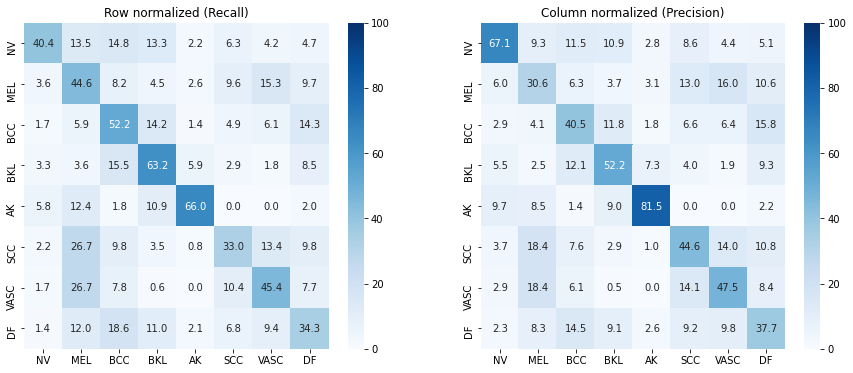

In [10]:
print_scores(model=model2, test_data=valid_data.take(valid_steps), labels=LABELS)

In [ ]:
model2.save(MODEL_DIR)

## 3rd Model

In [8]:
def build_model(func):
    def wrapper():
        pretrained_model = func()
        pretrained_model.trainable = True
        model = tf.keras.Sequential([
                pretrained_model,
                tf.keras.layers.GlobalAveragePooling2D(),
                tf.keras.layers.Dense(len(LABELS), activation='softmax')
                ])
        
        model.compile(
                optimizer='adam',
                loss = 'sparse_categorical_crossentropy',
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
        
        return model
    return wrapper

@build_model
def ResNet152V2():
    return tf.keras.applications.ResNet152V2(input_shape=[*IMAGE_SIZE, 3], include_top=False)

@build_model
def Xception():
    return tf.keras.applications.Xception(input_shape=[*IMAGE_SIZE, 3], include_top=False)

@build_model
def DenseNet121():
    return tf.keras.applications.DenseNet121(input_shape=[*IMAGE_SIZE, 3], include_top=False)

@build_model
def DenseNet169():
    return tf.keras.applications.DenseNet169(input_shape=[*IMAGE_SIZE, 3], include_top=False)

@build_model
def DenseNet201():
    return tf.keras.applications.DenseNet201(input_shape=[*IMAGE_SIZE, 3], include_top=False)

@build_model
def EfficientNetB0():
    return tf.keras.applications.EfficientNetB0(input_shape=[*IMAGE_SIZE, 3], include_top=False)

@build_model
def EfficientNetB1():
    return tf.keras.applications.EfficientNetB1(input_shape=[*IMAGE_SIZE, 3], include_top=False)

@build_model
def EfficientNetB2():
    return tf.keras.applications.EfficientNetB2(input_shape=[*IMAGE_SIZE, 3], include_top=False)

@build_model
def EfficientNetB3():
    return tf.keras.applications.EfficientNetB3(input_shape=[*IMAGE_SIZE, 3], include_top=False)

@build_model
def EfficientNetB4():
    return tf.keras.applications.EfficientNetB4(input_shape=[*IMAGE_SIZE, 3], include_top=False)

@build_model
def EfficientNetB5():
    return tf.keras.applications.EfficientNetB5(input_shape=[*IMAGE_SIZE, 3], include_top=False)

@build_model
def EfficientNetB6():
    return tf.keras.applications.EfficientNetB6(input_shape=[*IMAGE_SIZE, 3], include_top=False)

@build_model
def EfficientNetB7():
    return tf.keras.applications.EfficientNetB7(input_shape=[*IMAGE_SIZE, 3], include_top=False)

@build_model
def MobileNet():
    return tf.keras.applications.MobileNet(input_shape=[*IMAGE_SIZE, 3], include_top=False)

@build_model
def MobileNetV2():
    return tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)

@build_model
def NASNetMobile():
    return tf.keras.applications.NASNetMobile(input_shape=[*IMAGE_SIZE, 3], include_top=False, weights=None)


Learning rate per epoch:


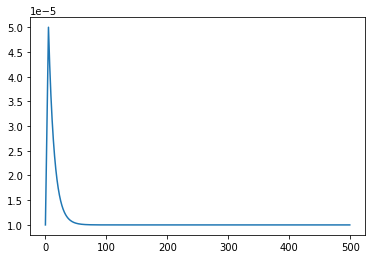

In [9]:
EPOCHS = 500


start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005 * strategy.num_replicas_in_sync
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .9

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
      
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

rang = tf.range(EPOCHS).numpy()
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

In [10]:
with strategy.scope():
    model3 = EfficientNetB2()

model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 5, 5, 1408)        7768569   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 11272     
Total params: 7,779,841
Trainable params: 7,712,266
Non-trainable params: 67,575
_________________________________________________________________


In [11]:
ES = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', min_delta=0.001, patience=20, mode='max', restore_best_weights=True)
TB = tf.keras.callbacks.TensorBoard(log_dir=os.path.join(LOGS_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10)
CKPT = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(CHECKPOINT_DIR, 'ckpt') , 
                                          monitor='val_sparse_categorical_accuracy', 
                                          mode='max', 
                                          save_best_only=True, 
                                          save_weights_only=True)
model3.fit(train_data, 
          validation_data=valid_data, 
          steps_per_epoch=train_steps, 
          epochs=3, 
          validation_steps=valid_steps, 
          verbose=1, 
          callbacks=[ES, TB, lr_callback, CKPT]
         )

Epoch 1/3
317/317 [==============================] - 96s 302ms/step - loss: 2.0187 - sparse_categorical_accuracy: 0.2114 - val_loss: 2.1256 - val_sparse_categorical_accuracy: 0.1268
Epoch 2/3
317/317 [==============================] - 94s 295ms/step - loss: 1.7632 - sparse_categorical_accuracy: 0.3392 - val_loss: 1.9880 - val_sparse_categorical_accuracy: 0.2309
Epoch 3/3
317/317 [==============================] - 93s 294ms/step - loss: 1.5320 - sparse_categorical_accuracy: 0.4346 - val_loss: 1.7247 - val_sparse_categorical_accuracy: 0.3690


In [ ]:
model_names = [DenseNet121, EfficientNetB3, MobileNetV2]

for n, model_name in enumerate(model_names):
    with strategy.scope():
        model = model_name()

    ES = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', min_delta=0.001, patience=20, mode='max', restore_best_weights=True)
    TB = tf.keras.callbacks.TensorBoard(log_dir=os.path.join(LOGS_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
    LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10)
    CKPT = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(CHECKPOINT_DIR, f'{n:02d}', 'ckpt') , 
                                          monitor='val_sparse_categorical_accuracy', 
                                          mode='max', 
                                          save_best_only=True, 
                                          save_weights_only=True)    

    model.fit(train_data, 
          validation_data=valid_data, 
          steps_per_epoch=train_steps, 
          epochs=EPOCHS, 
          validation_steps=valid_steps, 
          verbose=0, 
          callbacks=[ES, TB, lr_callback, CKPT]
         )
    
    print(f'Model {n+1}:')
    print_scores(model=model, test_data=valid_data.take(valid_steps), labels=LABELS)
    
    models.append(model)

In [ ]:
def mix_models(models):
    y_pred = tf.constant(value=0, shape=[0,8], dtype=tf.float32)
    y_true = tf.constant([], dtype=tf.int32)
    for x, y in valid_data.take(valid_steps):
        y_tmp = tf.zeros(shape=[y.shape[0], len(LABELS)], dtype=tf.float32)
        for model in models:
            y_tmp += model.predict(x)  
        y_pred = tf.concat([y_pred, y_tmp/len(models)], axis=0)
        y_true = tf.concat([y_true, tf.cast(y, tf.int32)], axis=0)
    y_cl = tf.math.argmax(y_pred, axis=1, output_type=tf.int32)
    print(f'Accuracy: {100 * accuracy_score(y_true, y_cl):.2f}%')
    print(f'AUC: {100* roc_auc_score(y_true, y_pred, multi_class="ovr"):.2f}%')
    print(f'Jaccard: {100 * jaccard_score(y_true, y_cl, average="macro"):.2f}%')
    print(f'F1: {100 * f1_score(y_true, y_cl, average="macro"):.2f}%')
    
    print('Confusion Matrix')
    cm = tf.math.confusion_matrix(y_true, y_cl)
    # cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    cmap = 'Blues'
    plt.figure(figsize=(15,6))
    plt.subplot(121)
    sns.heatmap(100*cm/tf.reduce_sum(cm, axis=1), annot=True, vmin=0.0, vmax=100., 
                    xticklabels = labels, yticklabels= labels, 
                    fmt='.1f', cmap=cmap)
    plt.title('Row normalized (Recall)')
    plt.subplot(122)
    sns.heatmap(100*cm/tf.reduce_sum(cm, axis=0), annot=True, vmin=0.0, vmax=100., 
                    xticklabels = labels, yticklabels= labels, 
                    fmt='.1f', cmap=cmap)
    plt.title('Column normalized (Precision)')
    plt.show() 




mix_models(models)

EfficientNetB2

In [10]:
test_data = valid_data.take(valid_steps)

Accuracy: 72.46%
AUC: 94.78%
Jaccard: 58.15%
F1: 72.54%
Confusion Matrix


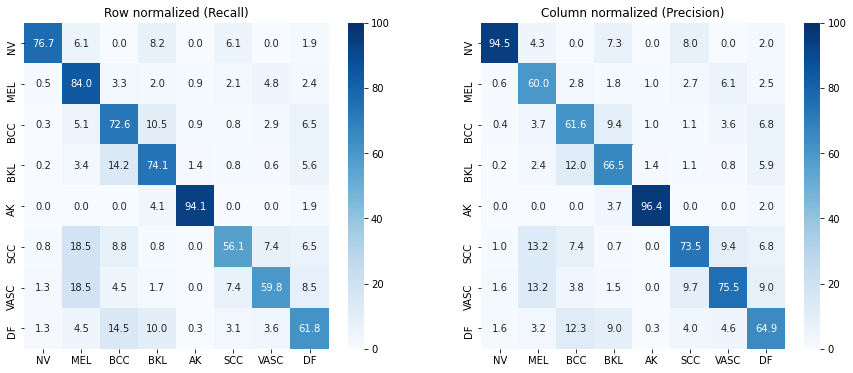

In [15]:
print_scores(model=model3, test_data=test_data, labels=LABELS)

Accuracy: 73.17%
AUC: 94.83%
Jaccard: 59.00%
F1: 73.34%
Confusion Matrix


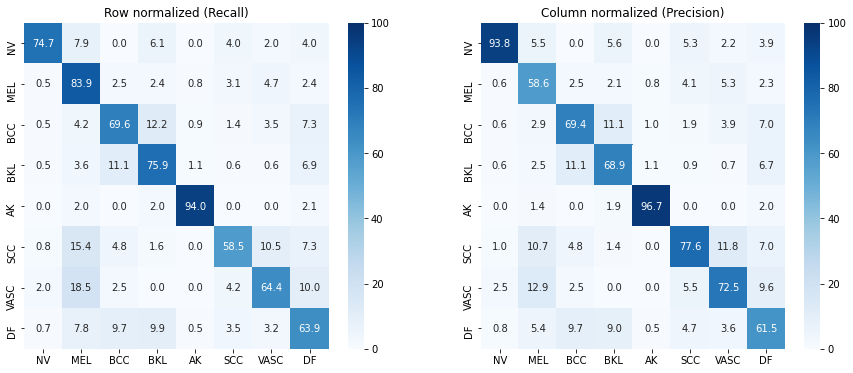

In [26]:
print_scores(model=model3, test_data=test_data, labels=LABELS)

DenseNet121

Accuracy: 72.52%
AUC: 94.92%
Jaccard: 58.14%
F1: 72.77%
Confusion Matrix


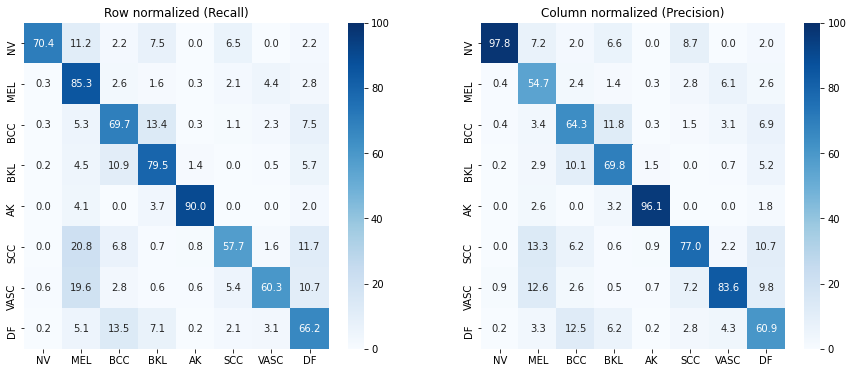

In [40]:
print_scores(model=model3, test_data=valid_data.take(valid_steps), labels=LABELS)

MobileNetV2

Accuracy: 71.14%
AUC: 94.57%
Jaccard: 56.62%
F1: 71.46%
Confusion Matrix


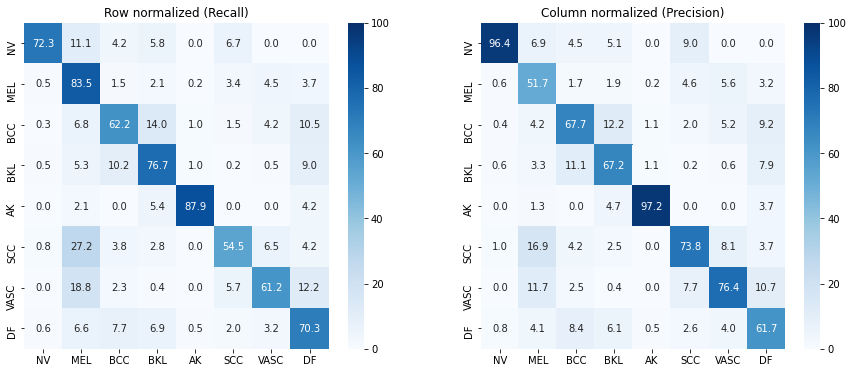

In [23]:
print_scores(model=model3, test_data=valid_data.take(valid_steps), labels=LABELS)

EfficientNetB3

Accuracy: 73.39%
AUC: 94.11%
Jaccard: 59.65%
F1: 74.02%
Confusion Matrix


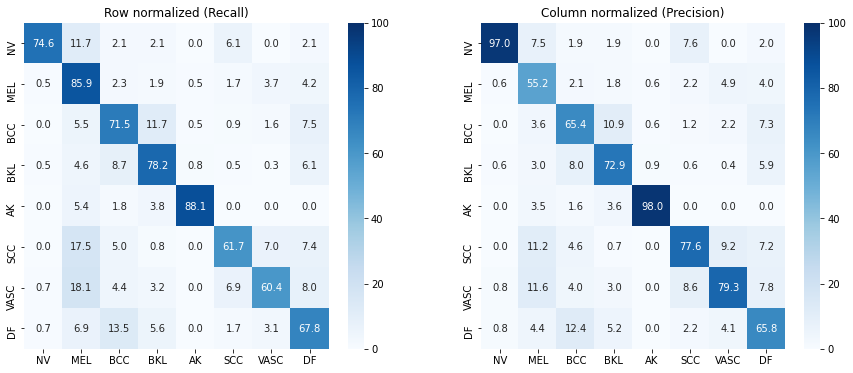

In [8]:
print_scores(model=model3, test_data=valid_data.take(valid_steps), labels=LABELS)

In [36]:
# Saving the newly trained EfficientNetB2

model3.save(os.path.join(MODEL_DIR, 'skin-cancer-detector/0003'))

In [10]:
from sklearn.metrics import roc_auc_score, jaccard_score, f1_score, accuracy_score

def compute_scores(model, test_data, labels):
    y_pred = tf.constant(value=0, shape=[0,8], dtype=tf.float32)
    y_true = tf.constant([], dtype=tf.int32)
    for x, y in test_data:
        y_pred = tf.concat([y_pred, model.predict(x)], axis=0)
        y_true = tf.concat([y_true, tf.cast(y, tf.int32)], axis=0)
    y_cl = tf.math.argmax(y_pred, axis=1, output_type=tf.int32)
    scores = {}
    scores['accuracy'] = accuracy_score(y_true, y_cl)
    scores['auc'] = roc_auc_score(y_true, y_pred, multi_class="ovr")
    scores['jaccard'] = jaccard_score(y_true, y_cl, average="macro")
    scores['f1'] = f1_score(y_true, y_cl, average="macro")
    del model
    del y_pred
    del y_true
    del y_cl
    return scores

In [11]:
import pandas as pd
import numpy as np

model_names = ['DenseNet121']
test_data = valid_data.take(valid_steps)

# initalizing a dictionary
scores = {}
for score in ['accuracy', 'auc', 'jaccard', 'f1']:
    scores[score] = {}

# computing the scores and writing them into the dictionary
for model_name in model_names:
    print(model_name)
    for n in range(10):
        print(n)
        model = tf.keras.models.load_model(os.path.join(MODEL_DIR, model_name, str(n)))
        _scores = compute_scores(model, test_data, LABELS)
        for score in ['accuracy' , 'auc', 'jaccard', 'f1']:
            scores[score][model_name][n] = _scores[score]

DenseNet121
0
1
2
3
4
5
6
7
8
9


In [13]:
import json
with open('results.json', 'w') as file: 
    json.dump(scores, file)

In [7]:
import json

with open('results.json', 'r') as file:
    scores = json.load(file)

In [16]:
import pandas as pd

Scores = {}
for key, item in scores.items():
    Scores[key] = pd.DataFrame(item)
    
Scores['accuracy']

,DenseNet121,EfficientNetB2,EfficientNetB3,MobileNetV2
0,0.732319,0.442710,0.463256,0.696760
1,0.731529,0.447847,0.371395,0.703872
2,0.721256,0.485579,0.371395,0.701699
3,0.738048,0.486171,0.432240,0.722047
4,0.751087,0.434018,0.339392,0.691031
5,0.736863,0.492691,0.466812,0.702292
6,0.746345,0.434808,0.429870,0.709996
7,0.742592,0.367049,0.352035,0.712959
8,0.731529,0.271237,0.504346,0.702884
9,0.742789,0.372185,0.238838,0.707823


In [17]:
Scores['auc']

,DenseNet121,EfficientNetB2,EfficientNetB3,MobileNetV2
0,0.950375,0.829653,0.843178,0.943560
1,0.943492,0.820751,0.788065,0.943220
2,0.945967,0.844866,0.798321,0.944893
3,0.947608,0.842557,0.803678,0.944337
4,0.952481,0.828577,0.765107,0.941912
5,0.949290,0.847441,0.843576,0.942744
6,0.948589,0.815457,0.836680,0.944919
7,0.948064,0.785421,0.777890,0.944732
8,0.947822,0.726042,0.856447,0.944008
9,0.948428,0.788901,0.686040,0.942328


In [18]:
Scores['jaccard']

,DenseNet121,EfficientNetB2,EfficientNetB3,MobileNetV2
0,0.588680,0.290086,0.306468,0.545339
1,0.588422,0.285256,0.225038,0.556160
2,0.575113,0.318638,0.217371,0.552608
3,0.596656,0.327806,0.277840,0.578390
4,0.613263,0.276565,0.196149,0.539767
5,0.598489,0.332762,0.310070,0.551614
6,0.605120,0.280959,0.276496,0.561323
7,0.602896,0.213180,0.212871,0.565638
8,0.590031,0.127918,0.341749,0.552976
9,0.601794,0.224515,0.107998,0.560211


In [19]:
Scores['f1']

,DenseNet121,EfficientNetB2,EfficientNetB3,MobileNetV2
0,0.734813,0.443858,0.466360,0.702090
1,0.731449,0.438792,0.363977,0.709435
2,0.722341,0.478707,0.352683,0.705954
3,0.740188,0.486286,0.430075,0.726307
4,0.753624,0.428271,0.320160,0.695136
5,0.740917,0.493477,0.470059,0.704712
6,0.747157,0.436186,0.430849,0.713973
7,0.743293,0.345891,0.347447,0.716610
8,0.734432,0.218671,0.505587,0.706420
9,0.743001,0.363201,0.188943,0.708588


In [21]:
Scores['accuracy'].idxmax()

DenseNet121       4
EfficientNetB2    5
EfficientNetB3    8
MobileNetV2       3
dtype: int64

In [22]:
Scores['auc'].idxmax()

DenseNet121       4
EfficientNetB2    5
EfficientNetB3    8
MobileNetV2       6
dtype: int64

In [23]:
Scores['jaccard'].idxmax()

DenseNet121       4
EfficientNetB2    5
EfficientNetB3    8
MobileNetV2       3
dtype: int64

In [24]:
Scores['f1'].idxmax()

DenseNet121       4
EfficientNetB2    5
EfficientNetB3    8
MobileNetV2       3
dtype: int64

In [7]:
densenet = tf.keras.models.load_model(os.path.join(MODEL_DIR, 'DenseNet121', '4'))
densenet_2 = tf.keras.models.load_model(os.path.join(MODEL_DIR, 'DenseNet121', '7'))
mobilenet = tf.keras.models.load_model(os.path.join(MODEL_DIR, 'MobileNetV2', '3'))

In [37]:
model3._name = 'seq_4'

The following model5 is a combination of densenet, densenet_2 and model3 from above.

In [48]:
x = tf.keras.layers.Input(shape=[*IMAGE_SIZE, 3])
y = (densenet(x) + densenet_2(x)+ model3(x))/3
model5 = tf.keras.models.Model(x, y)

In [24]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 8)            7045704     input_2[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 8)            7045704     input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_AddV2_3 (TensorFlow (None, 8)            0           sequential_4[0][0]               
                                                                 sequential_2[0][0]    

Accuracy: 77.32%
AUC: 96.27%
Jaccard: 63.92%
F1: 77.35%
Confusion Matrix


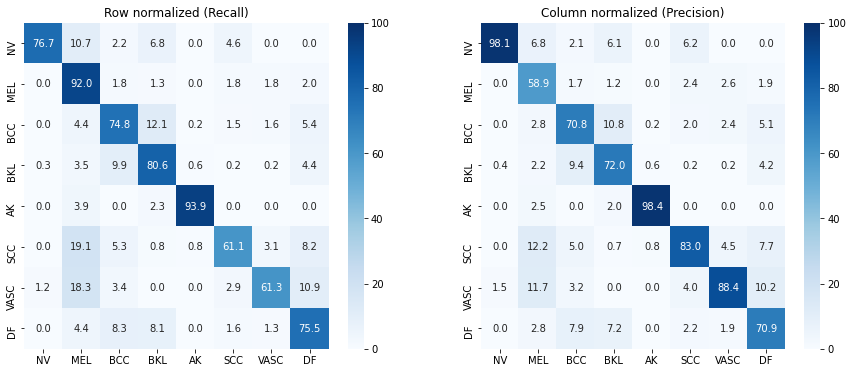

In [20]:
print_scores(model, valid_data.take(valid_steps), LABELS )

In [16]:
model.save(os.path.join(MODEL_DIR, 'skin-cancer-detector/0001'))

The following c_model is a combination of densenet, densenet_2 and mobilenet from above.

In [15]:
c_model = tf.keras.models.load_model(os.path.join(MODEL_DIR, 'skin-cancer-detector/0001'))

In [27]:
x = tf.keras.layers.Input(shape=[*IMAGE_SIZE, 3])
y = c_model(x)*0.75 + model3(x) * 0.25
model = tf.keras.models.Model(x, y)

Accuracy: 73.17%
AUC: 94.83%
Jaccard: 59.00%
F1: 73.34%
Confusion Matrix


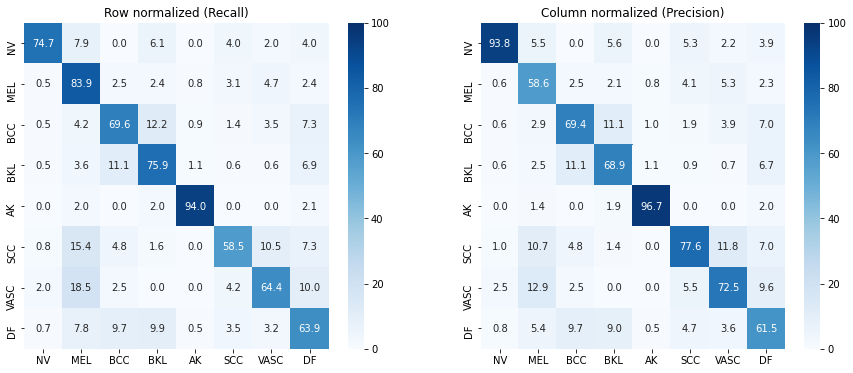

Accuracy: 77.08%
AUC: 96.25%
Jaccard: 63.92%
F1: 77.34%
Confusion Matrix


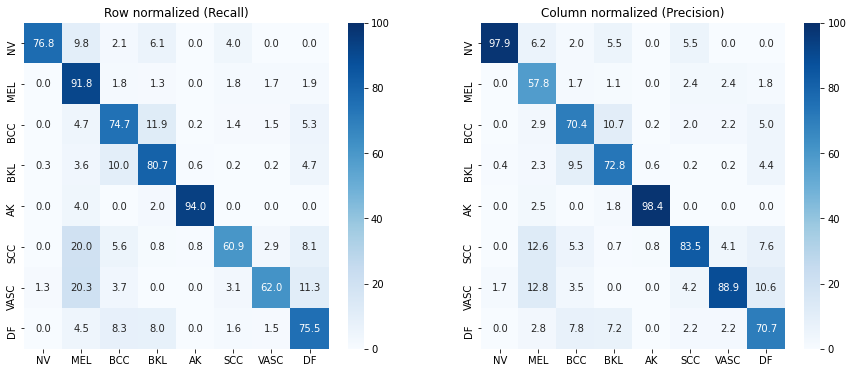

Accuracy: 76.99%
AUC: 96.64%
Jaccard: 63.78%
F1: 77.27%
Confusion Matrix


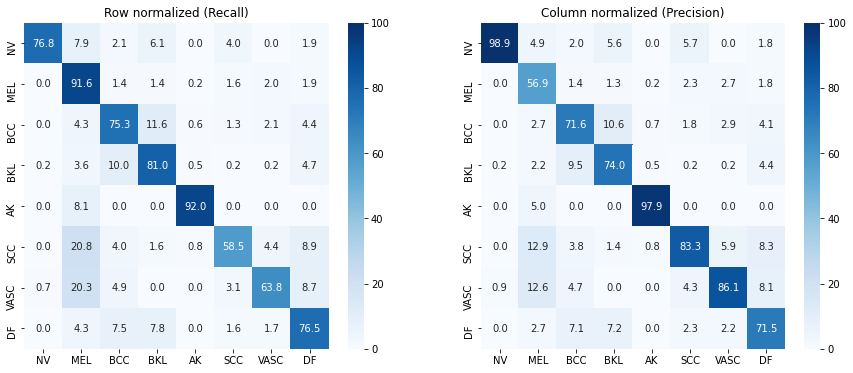

In [53]:
print_scores(model3, test_data, LABELS )
print_scores(c_model, test_data, LABELS )
print_scores(model, test_data, LABELS )

Accuracy: 77.62%
AUC: 96.39%
Jaccard: 64.67%
F1: 77.88%
Confusion Matrix


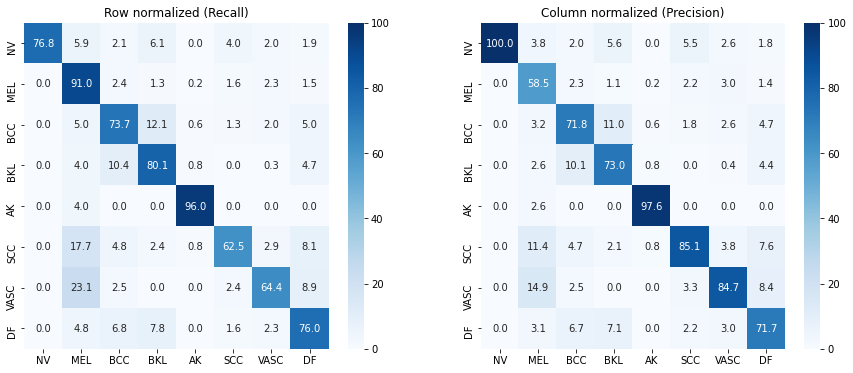

In [39]:
print_scores(model4, test_data, LABELS )

Accuracy: 77.62%
AUC: 96.39%
Jaccard: 64.67%
F1: 77.88%
Confusion Matrix


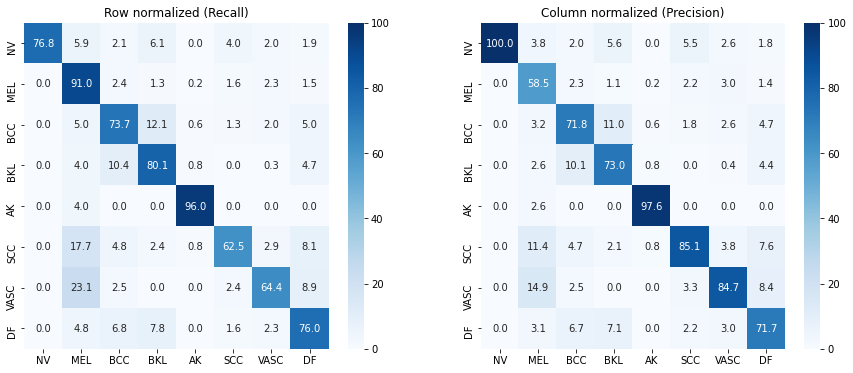

In [52]:
print_scores(model5, test_data, LABELS )

In [54]:
model5.save(os.path.join(MODEL_DIR, 'skin-cancer-detector/0002'))

The following model5 is a combination of densenet, densenet_2 and model3 from above.

In [8]:
model5 = tf.keras.models.load_model(os.path.join(MODEL_DIR, 'skin-cancer-detector/0002'))

Accuracy: 77.58%
AUC: 96.35%
Jaccard: 64.52%
F1: 77.76%
Confusion Matrix


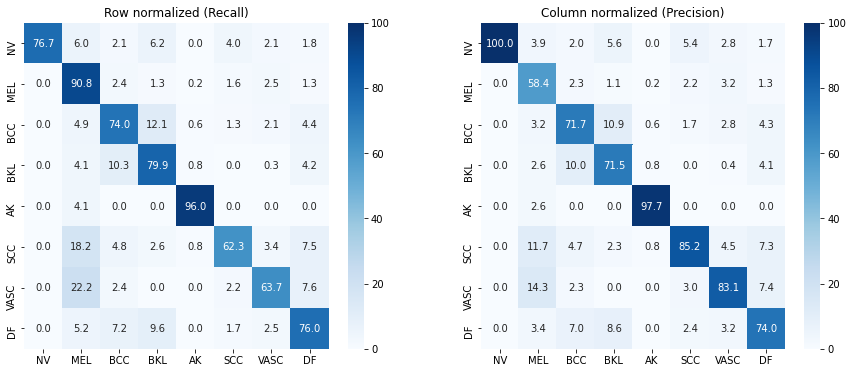

In [11]:
print_scores(model5, test_data, LABELS )

The following c_model is a combination of densenet, densenet_2 and mobilenet from above.

Accuracy: 77.01%
AUC: 96.21%
Jaccard: 63.74%
F1: 77.20%
Confusion Matrix


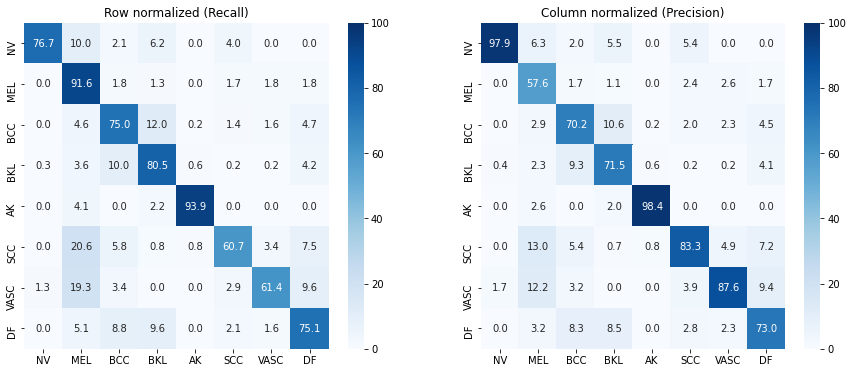

In [18]:
print_scores(c_model, test_data, LABELS )

model6 is an equal mix of mobilenet, model3, densenet, densenet_2

In [ ]:
x = tf.keras.layers.Input(shape=[*IMAGE_SIZE, 3])
y = c_model(x)*0.75 + model5(x) * 0.75 - (densenet(x)+ densenet_2(x))*0.25
model6 = tf.keras.models.Model(x, y)

Accuracy: 76.89%
AUC: 96.60%
Jaccard: 63.57%
F1: 77.10%
Confusion Matrix


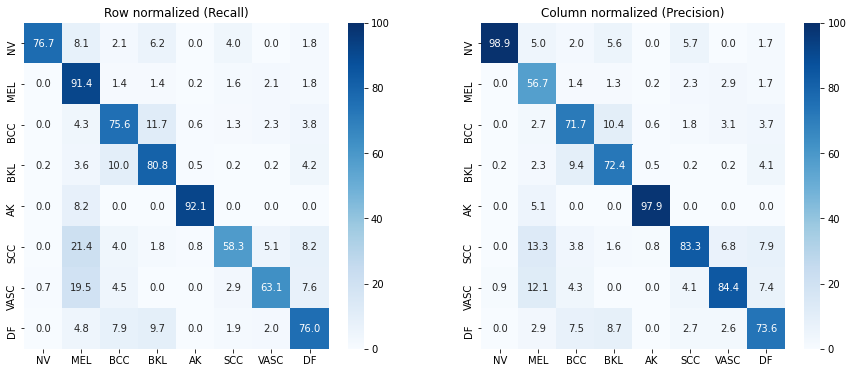

In [20]:
print_scores(model6, test_data, LABELS )

Accuracy: 77.56%
AUC: 96.57%
Jaccard: 64.51%
F1: 77.75%
Confusion Matrix


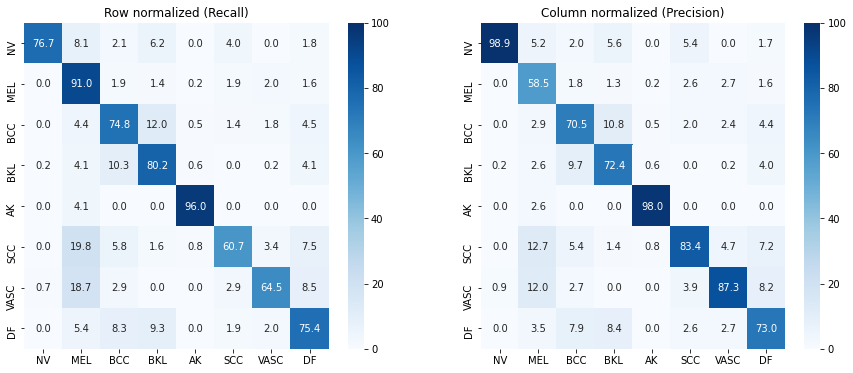

In [21]:
x = tf.keras.layers.Input(shape=[*IMAGE_SIZE, 3])
y = c_model(x)*0.5 + model5(x) * 0.5
model7 = tf.keras.models.Model(x, y)

print_scores(model7, test_data, LABELS )

Accuracy: 73.05%
AUC: 94.78%
Jaccard: 58.84%
F1: 73.22%
Confusion Matrix


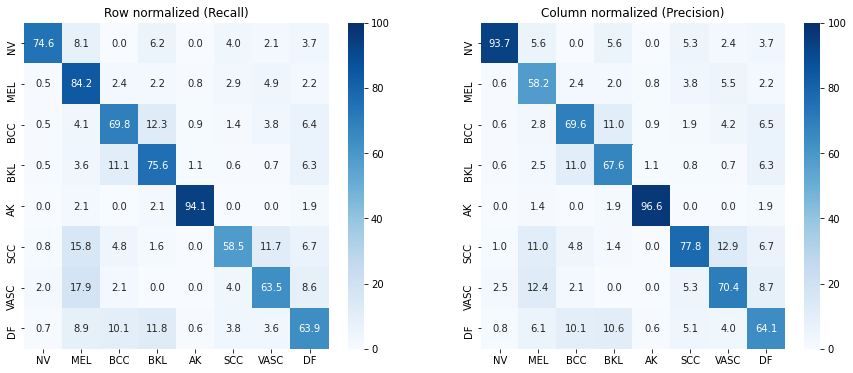

In [38]:
# This should reproduce the former model3 which was most likely EfficientNetB2

x = tf.keras.layers.Input(shape=[*IMAGE_SIZE, 3])
y = 3*model5(x) - densenet(x) - densenet_2(x)
model8 = tf.keras.models.Model(x, y)

print_scores(model8, test_data, LABELS )

Accuracy: 74.97%
AUC: 95.21%
Jaccard: 61.23%
F1: 75.30%
Confusion Matrix


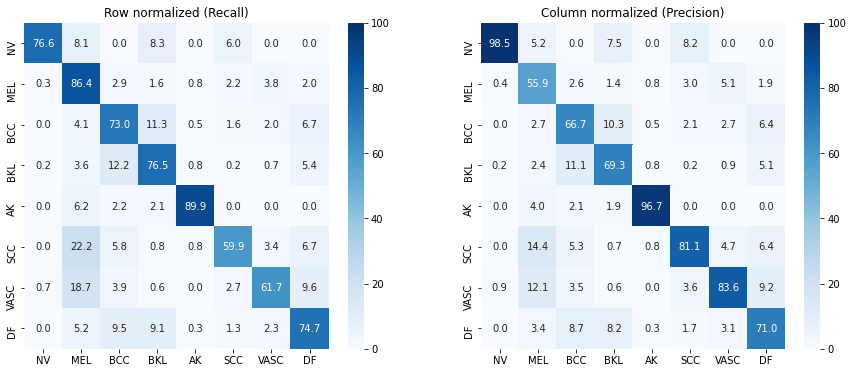

In [28]:
print_scores(densenet, test_data, LABELS )

Accuracy: 74.00%
AUC: 94.76%
Jaccard: 60.11%
F1: 74.19%
Confusion Matrix


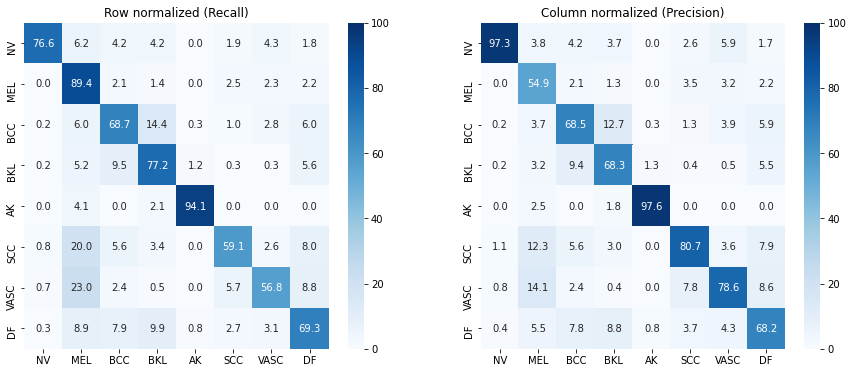

In [29]:
print_scores(densenet_2, test_data, LABELS )

Accuracy: 72.20%
AUC: 94.41%
Jaccard: 57.72%
F1: 72.53%
Confusion Matrix


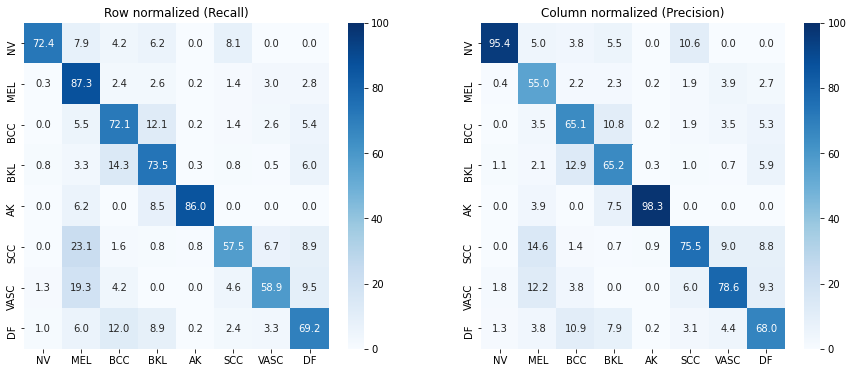

In [30]:
print_scores(mobilenet, test_data, LABELS )

Accuracy: 73.05%
AUC: 94.92%
Jaccard: 59.32%
F1: 73.36%
Confusion Matrix


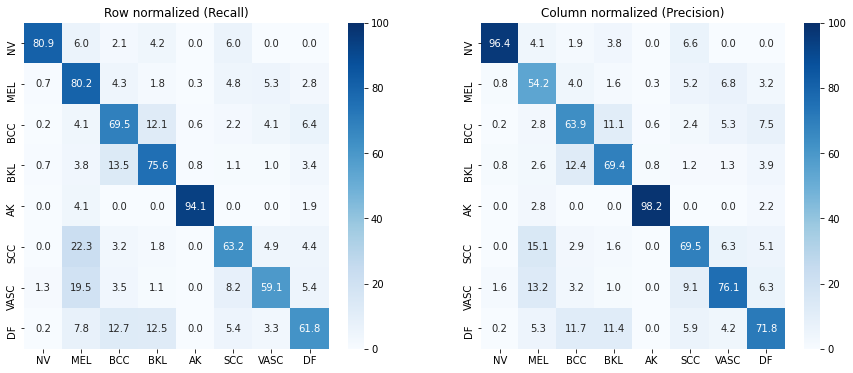

In [39]:
# This is an EfficientNetB2 saved under models/0003/skin-cancer-detector/0003

print_scores(model3, test_data, LABELS )

Accuracy: 77.46%
AUC: 96.62%
Jaccard: 64.48%
F1: 77.65%
Confusion Matrix


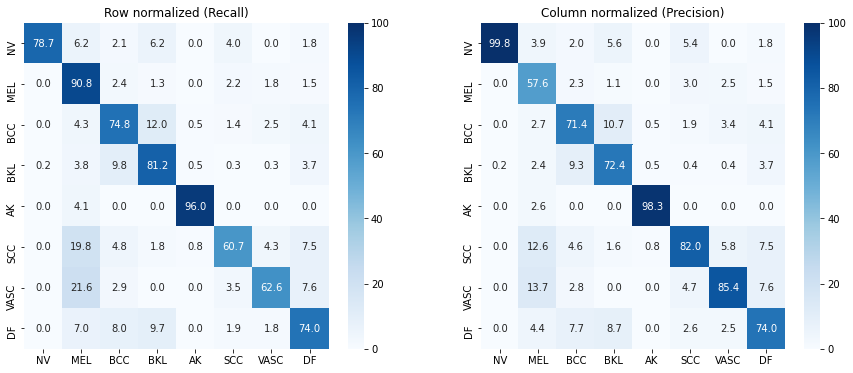

In [37]:
x = tf.keras.layers.Input(shape=[*IMAGE_SIZE, 3])
y = ( densenet(x) + densenet_2(x) + model3(x))/3
model9 = tf.keras.models.Model(x, y)

print_scores(model9, test_data, LABELS )

Accuracy: 77.78%
AUC: 96.70%
Jaccard: 64.83%
F1: 77.94%
Confusion Matrix


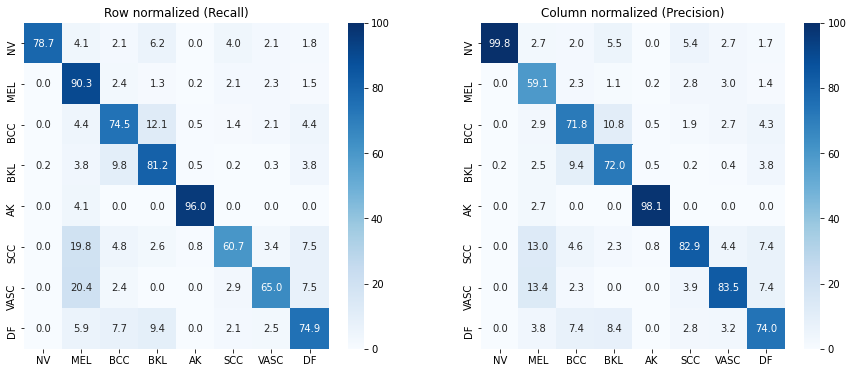

In [40]:
x = tf.keras.layers.Input(shape=[*IMAGE_SIZE, 3])
y = ( model9(x) + model5(x))/2
model10 = tf.keras.models.Model(x, y)

print_scores(model10, test_data, LABELS )

In [41]:
model10.save(os.path.join(MODEL_DIR, 'skin-cancer-detector/0004'))